### Using the free water elimination model to remove DTI free water contamination

The diffusion tensor model is a simple way to characterize diffusion anisotropy. However, in regions near the cerebral ventricle and parenchyma can be underestimated by partial volume effects of the cerebral spinal fluid (CSF). This free water contamination can particularly corrupt Diffusion Tensor Imaging analysis of microstructural changes when different groups of subjects show different brain morphology (e.g. brain ventricle enlargement associated with brain tissue atrophy that occurs in several brain pathologies and ageing).

A way to remove this free water influences is to expand the DTI model to take into account an extra compartment representing the contributions of free water diffusion [Pasternak2009](https://pubmed.ncbi.nlm.nih.gov/19623619/). The expression of the expanded DTI model is shown below:


$S(n,b) = S_0 (1 - f) exp(-b n^T D n) + S_0 f exp(-bD_{iso})$

$D_{iso}$ is the scalar free water diffusion coefficient at 37$^o$ ($D_{iso}=\times 10^{-3} mm^2/s$ ).

In this example, we show how to process a diffusion weighting dataset using an adapted version of the free water elimination proposed by ([Hoy2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4312191/)).

The full details of Dipy’s free water DTI implementation was published in ([Henriques2017](http://rescience.github.io/bibliography/henriques_2017.html)). Please cite this work if you use this algorithm.

Let’s start by importing the relevant modules:

In [1]:
import numpy as np
import dipy.reconst.fwdti as fwdti
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu

## 1) Load data

To fit the fwDTI model we need data for at least two non-zero b-values. Thus, for this tutorial, we download a dataset that was required from multiple b-values.

In [2]:
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

#fraw = 'C:\\Users\\rafae\\.dipy\\cfin_multib\\__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.nii'
#fbval = 'C:\\Users\\rafae\\.dipy\\cfin_multib\\__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.bval'
#fbvec = 'C:\\Users\\rafae\\.dipy\\cfin_multib\\__DTI_AX_ep2d_2_5_iso_33d_20141015095334_4.bvec'

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

From the downloaded data, we use only the data acquired with b-values up to 2000 s/mm2 to decrease the influence of non-Gaussian diffusion effects of the tissue which are not taken into account by the free water elimination model.

In [3]:
data = data[:, :, :, bvals<2100]
gtab = gradient_table(bvals[bvals<2100], bvecs[bvals<2100, :])

The free water DTI model can take some minutes to process the full data set. Thus, we remove the background of the image to avoid unnecessary calculations.

In [4]:
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

Moreover, for illustration purposes we process only an axial slice of the data.

In [5]:
axial_slice = 9

mask_roi = np.zeros(data.shape[:-1], dtype=bool)
mask_roi[:, :, axial_slice] = mask[:, :, axial_slice]

## 2) Fit data

The free water elimination model fit can then be initialized by instantiating a FreeWaterTensorModel class object:

In [6]:
fwdtimodel = fwdti.FreeWaterTensorModel(gtab)

The data can then be fitted using the fit function of the defined model object:

In [7]:
fwdtifit = fwdtimodel.fit(data, mask=mask_roi)

100%|█████████████████████████████████████████████████████████████████████████████| 3121/3121 [00:14<00:00, 213.56it/s]


This 2-steps procedure will create a FreeWaterTensorFit object which contains all the diffusion tensor statistics free for free water contaminations. Below we extract the fractional anisotropy (FA), the mean diffusivity (MD) of the tissue diffusion tensor, and the free water volume fraction.

In [8]:
FA = fwdtifit.fa
MD = fwdtifit.md
F = fwdtifit.f

For comparison we also compute the FA and MD maps from the standard DTI model.

In [9]:
dtimodel = dti.TensorModel(gtab)

dtifit = dtimodel.fit(data, mask=mask_roi)

dti_FA = dtifit.fa
dti_MD = dtifit.md

Below the FA values for both free water elimination DTI model and standard DTI model are plotted in panels A and B, while the differences between these two metrics are shown in panels C. In addition to the standard diffusion statistics, the estimated volume fraction of the free water contamination is shown on panel D.

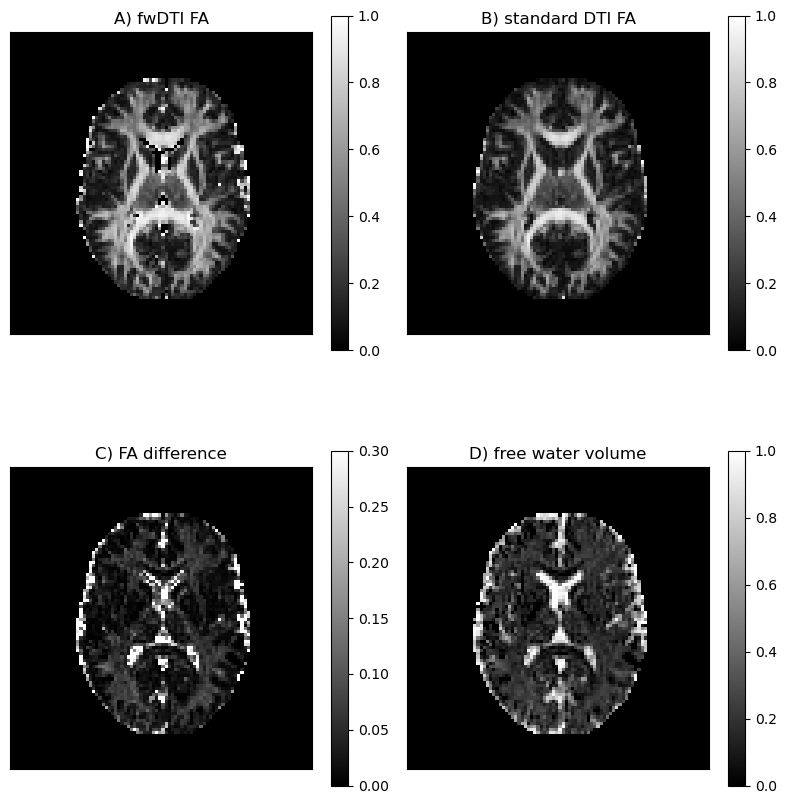

In [10]:
fig1, ax = plt.subplots(2, 2, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
im0 = ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')
im1 = ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
im2 = ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=0.3)
ax.flat[2].set_title('C) FA difference')

im3 = ax.flat[3].imshow(F[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[3].set_title('D) free water volume')

fig1.colorbar(im0, ax=ax.flat[0])
fig1.colorbar(im1, ax=ax.flat[1])
fig1.colorbar(im2, ax=ax.flat[2])
fig1.colorbar(im3, ax=ax.flat[3])

From the figure, one can observe that the free water elimination model produces in general higher values of FA than the standard DTI model. These differences in FA estimation are expected due to the suppression of the free water isotropic diffusion components. Unexpected high amplitudes of FA are however observed in the periventricular gray matter. This is a known artefact of regions associated to voxels with high water volume fraction (i.e. voxels containing basically CSF). We are able to remove this problematic voxels by excluding all FA values associated with measured volume fractions above a reasonable threshold of 0.7:

In [11]:
FA[F > 0.7] = 0
dti_FA[F > 0.7] = 0

Above we reproduce the plots of the in vivo FA from the two DTI fits and where we can see that the inflated FA values were practically removed:

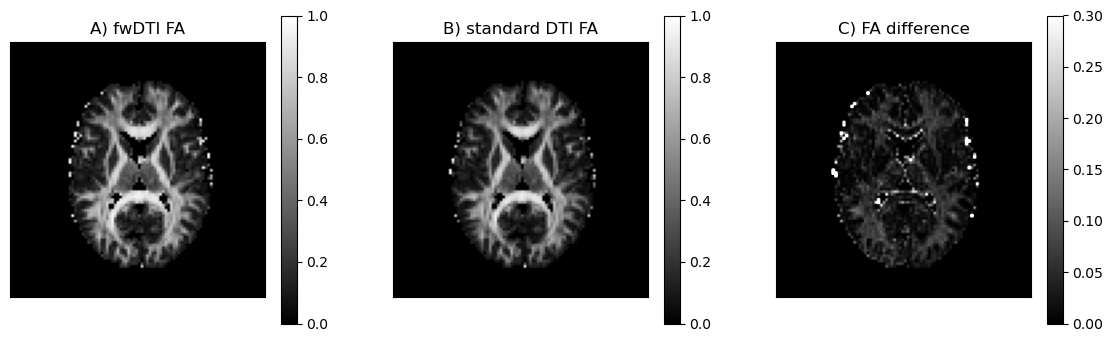

In [12]:
fig3, ax = plt.subplots(1, 3, figsize=(14, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
im0 = ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')
im1 = ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
im2 = ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=0.3)
ax.flat[2].set_title('C) FA difference')

fig3.colorbar(im0, ax=ax.flat[0])
fig3.colorbar(im1, ax=ax.flat[1])
fig3.colorbar(im2, ax=ax.flat[2])